In [25]:
import re
import torch
import time
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

In [28]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

In [29]:
print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [30]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [31]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [32]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [33]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [34]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [35]:
def preprocess(text):
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    text = normalize_alay(text) # 3

    return text

In [36]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


In [37]:
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 2e-5

In [38]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [39]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

In [40]:
def get_dataloaders(sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

In [41]:
manager = Manager()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

In [42]:
def train_model(sequence_length, model_name, metrics, seed=42, layers_freezed=6, num_workers=4):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=12,
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < layers_freezed:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    train_loader, val_loader = get_dataloaders(sequence_length, num_workers)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()
        
        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            best_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'model-{BATCH_SIZE}-{sequence_length}-{layers_freezed}-{seed}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time

    if accelerator.is_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])
        
    accelerator.print(f"\nAccuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Duration: {duration}")

In [43]:
# Tokenize each text and calculate their lengths
token_lengths = [len(tokenizer.tokenize(text)) for text in X_train]

# Calculate the average length
average_length = sum(token_lengths) / len(token_lengths)
max_length = max(token_lengths)

print("Average length of tokenized text:", average_length)
print("Max token length:", max_length)

Average length of tokenized text: 19.78690080683436
Max token length: 83


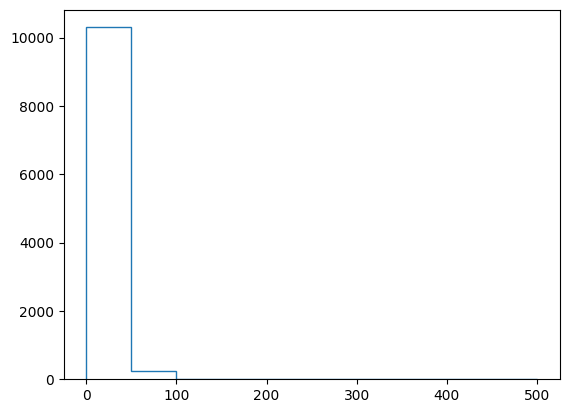

In [44]:
counts, bins = np.histogram(token_lengths, range=(0, 500))
plt.stairs(counts, bins)
plt.show()

In [45]:
sizes = [64, 96]
lengths = [48, 64, 80, 96]

used_sizes = []
used_lengths = []

for size in sizes:
    BATCH_SIZE = size
    for length in lengths:
        print("=========================================================================================")
        print(f"Batch size: {BATCH_SIZE}, sequence length: {length}")
        used_sizes.append(BATCH_SIZE)
        used_lengths.append(length)
        
        args = (length, 'indobenchmark/indobert-base-p1', (accuracies, f1_micros, f1_macros), 42, 6)
        notebook_launcher(train_model, args, num_processes=2)

Batch size: 64, sequence length: 48
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3801, Accuracy: 0.8846, F1 Micro: 0.5903, F1 Macro: 0.2898
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2567, Accuracy: 0.9055, F1 Micro: 0.7191, F1 Macro: 0.5368
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.913, F1 Micro: 0.7267, F1 Macro: 0.5755
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.92, F1 Micro: 0.7585, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1418, Accuracy: 0.9186, F1 Micro: 0.7664, F1 Macro: 0.6192
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9235, F1 Micro: 0.7737, F1 Macro: 0.6715
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.9209, F1 Micro: 0.7679, F1 Macro: 0.6674
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9234, F1 Micro: 0.7686, F1 Macro: 0.6729
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9198, F1 Micro: 0.7688, F1 Macro: 0.6664
Epoch 10/10, Train Loss: 0.062, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3798, Accuracy: 0.8858, F1 Micro: 0.6017, F1 Macro: 0.2979
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.9053, F1 Micro: 0.7212, F1 Macro: 0.5394
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.913, F1 Micro: 0.7263, F1 Macro: 0.5748
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9207, F1 Micro: 0.7608, F1 Macro: 0.6145
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9207, F1 Micro: 0.7708, F1 Macro: 0.6234
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9221, F1 Micro: 0.7737, F1 Macro: 0.6812
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.9205, F1 Micro: 0.7709, F1 Macro: 0.6793
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9237, F1 Micro: 0.7666, F1 Macro: 0.6718
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9243, F1 Micro: 0.7737, F1 Macro: 0.6861
Epoch 10/10, Train Loss: 0.0624, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3802, Accuracy: 0.8852, F1 Micro: 0.5962, F1 Macro: 0.2915
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2559, Accuracy: 0.9066, F1 Micro: 0.7203, F1 Macro: 0.532
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2051, Accuracy: 0.9125, F1 Micro: 0.7236, F1 Macro: 0.57
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9195, F1 Micro: 0.7573, F1 Macro: 0.6077
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9212, F1 Micro: 0.7735, F1 Macro: 0.6287
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.923, F1 Micro: 0.7746, F1 Macro: 0.6704
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9213, F1 Micro: 0.7701, F1 Macro: 0.6681
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9244, F1 Micro: 0.7716, F1 Macro: 0.6641
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.925, F1 Micro: 0.7751, F1 Macro: 0.6835
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.379, Accuracy: 0.8833, F1 Micro: 0.5701, F1 Macro: 0.2801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2552, Accuracy: 0.9058, F1 Micro: 0.7194, F1 Macro: 0.5429
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9135, F1 Micro: 0.72, F1 Macro: 0.5681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9211, F1 Micro: 0.7585, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9198, F1 Micro: 0.7687, F1 Macro: 0.6243
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1186, Accuracy: 0.9213, F1 Micro: 0.7726, F1 Macro: 0.671
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9191, F1 Micro: 0.7666, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9236, F1 Micro: 0.7795, F1 Macro: 0.6787
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9233, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4168, Accuracy: 0.8775, F1 Micro: 0.5399, F1 Macro: 0.2467
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2817, Accuracy: 0.8974, F1 Micro: 0.6965, F1 Macro: 0.4859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2333, Accuracy: 0.9071, F1 Micro: 0.7254, F1 Macro: 0.5553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1963, Accuracy: 0.9153, F1 Micro: 0.7508, F1 Macro: 0.5974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1668, Accuracy: 0.9208, F1 Micro: 0.758, F1 Macro: 0.5951
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1501, Accuracy: 0.9225, F1 Micro: 0.7656, F1 Macro: 0.6262
Epoch 7/10, Train Loss: 0.1254, Accuracy: 0.921, F1 Micro: 0.7654, F1 Macro: 0.6355
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1081, Accuracy: 0.9177, F1 Micro: 0.7708, F1 Macro: 0.6471
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0924, Accuracy: 0.9247, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4154, Accuracy: 0.878, F1 Micro: 0.5426, F1 Macro: 0.2485
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2814, Accuracy: 0.8967, F1 Micro: 0.695, F1 Macro: 0.4835
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2338, Accuracy: 0.9056, F1 Micro: 0.7247, F1 Macro: 0.5574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1955, Accuracy: 0.9168, F1 Micro: 0.738, F1 Macro: 0.5775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1678, Accuracy: 0.9207, F1 Micro: 0.7587, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1501, Accuracy: 0.9212, F1 Micro: 0.7671, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1261, Accuracy: 0.9208, F1 Micro: 0.7682, F1 Macro: 0.6312
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1068, Accuracy: 0.9206, F1 Micro: 0.771, F1 Macro: 0.642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.09

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4152, Accuracy: 0.8772, F1 Micro: 0.5344, F1 Macro: 0.2448
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.281, Accuracy: 0.8969, F1 Micro: 0.6998, F1 Macro: 0.4947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2328, Accuracy: 0.9088, F1 Micro: 0.725, F1 Macro: 0.5539
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1943, Accuracy: 0.9157, F1 Micro: 0.7508, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1668, Accuracy: 0.9195, F1 Micro: 0.7597, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1492, Accuracy: 0.9226, F1 Micro: 0.7656, F1 Macro: 0.6246
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1255, Accuracy: 0.9202, F1 Micro: 0.7707, F1 Macro: 0.6422
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1065, Accuracy: 0.9199, F1 Micro: 0.7733, F1 Macro: 0.6355
Epoch 9/10, Train Loss: 0.0939, Accuracy: 0.9246, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4164, Accuracy: 0.8782, F1 Micro: 0.547, F1 Macro: 0.2516
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2808, Accuracy: 0.8962, F1 Micro: 0.6998, F1 Macro: 0.4952
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2339, Accuracy: 0.9075, F1 Micro: 0.7282, F1 Macro: 0.5558
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1957, Accuracy: 0.9165, F1 Micro: 0.7462, F1 Macro: 0.5876
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1678, Accuracy: 0.9192, F1 Micro: 0.7543, F1 Macro: 0.5908
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1492, Accuracy: 0.9204, F1 Micro: 0.7653, F1 Macro: 0.6189
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1283, Accuracy: 0.9227, F1 Micro: 0.7757, F1 Macro: 0.6324
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1062, Accuracy: 0.9228, F1 Micro: 0.7765, F1 Macro: 0.6466
Epoch 9/10, Train Loss: 0.0927, Accuracy: 0.924, F1 Micro

In [46]:
results = pd.DataFrame({
    'Batch Size': used_sizes,
    'Sequence Length': used_lengths,
    'Accuracy': list(accuracies),
    'F1 Micro': list(f1_micros),
    'F1 Macro': list(f1_macros),
})

results.to_csv(f'hyperparameters_tuning.csv', index=False)

# USE BEST CONFIG

In [49]:
seeds = [50, 81, 14, 3, 94]

accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

for seed in seeds:
    print("=====================")
    print("SEED:", seed)
    set_seed(seed)
    
    LEARNING_RATE = 2e-5
    BATCH_SIZE = 64
    args = (80, 'indobenchmark/indobert-base-p1', (accuracies, f1_micros, f1_macros), seed, 6)
    
    notebook_launcher(train_model, args, num_processes=2)

SEED: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3752, Accuracy: 0.8872, F1 Micro: 0.608, F1 Macro: 0.3094
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2535, Accuracy: 0.907, F1 Micro: 0.7214, F1 Macro: 0.5371
Epoch 3/10, Train Loss: 0.2037, Accuracy: 0.9119, F1 Micro: 0.7169, F1 Macro: 0.5595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9193, F1 Micro: 0.7626, F1 Macro: 0.6295
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9213, F1 Micro: 0.7689, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.923, F1 Micro: 0.7742, F1 Macro: 0.6859
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9183, F1 Micro: 0.7647, F1 Macro: 0.6776
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9245, F1 Micro: 0.7749, F1 Macro: 0.6912
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.9234, F1 Micro: 0.7665, F1 Macro: 0.6816
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3695, Accuracy: 0.8847, F1 Micro: 0.5729, F1 Macro: 0.2869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9083, F1 Micro: 0.7295, F1 Macro: 0.5529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9147, F1 Micro: 0.7325, F1 Macro: 0.5758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1683, Accuracy: 0.9197, F1 Micro: 0.7625, F1 Macro: 0.6163
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.9209, F1 Micro: 0.7703, F1 Macro: 0.6301
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.9233, F1 Micro: 0.7744, F1 Macro: 0.6612
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.9213, F1 Micro: 0.7628, F1 Macro: 0.6606
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9232, F1 Micro: 0.7731, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9265, F1 Micro: 0.7809, F1 Macro: 0.6889
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3643, Accuracy: 0.8883, F1 Micro: 0.6067, F1 Macro: 0.3254
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2481, Accuracy: 0.9092, F1 Micro: 0.732, F1 Macro: 0.5566
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.9155, F1 Micro: 0.7311, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9197, F1 Micro: 0.7623, F1 Macro: 0.6256
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.9203, F1 Micro: 0.7708, F1 Macro: 0.6342
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9224, F1 Micro: 0.7751, F1 Macro: 0.687
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9211, F1 Micro: 0.7756, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9258, F1 Micro: 0.7801, F1 Macro: 0.6878
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9238, F1 Micro: 0.7764, F1 Macro: 0.6821
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3724, Accuracy: 0.8876, F1 Micro: 0.6063, F1 Macro: 0.3051
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2523, Accuracy: 0.9059, F1 Micro: 0.7265, F1 Macro: 0.5438
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9132, F1 Micro: 0.7176, F1 Macro: 0.5534
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9208, F1 Micro: 0.7634, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.923, F1 Micro: 0.7678, F1 Macro: 0.624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9226, F1 Micro: 0.7757, F1 Macro: 0.6882
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9217, F1 Micro: 0.7691, F1 Macro: 0.6842
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.9245, F1 Micro: 0.7749, F1 Macro: 0.6898
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9214, F1 Micro: 0.7771, F1 Macro: 0.7114
Epoch 10/10, Train Loss: 0.0621, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8885, F1 Micro: 0.6166, F1 Macro: 0.3134
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.9068, F1 Micro: 0.7293, F1 Macro: 0.5472
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.9127, F1 Micro: 0.7219, F1 Macro: 0.5723
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9198, F1 Micro: 0.7674, F1 Macro: 0.617
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.922, F1 Micro: 0.7681, F1 Macro: 0.6206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.923, F1 Micro: 0.7775, F1 Macro: 0.6773
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9236, F1 Micro: 0.7732, F1 Macro: 0.6883
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9257, F1 Micro: 0.7773, F1 Macro: 0.6871
Epoch 9/10, Train Loss: 0.0717, Accuracy: 0.9241, F1 Micro: 0.7769, F1 Macro: 0.6997
Epoch 10/10, Train Loss: 0.0625, Accuracy: 0.9209, F1 Micro: 0.7677, F1 M

In [50]:
results = pd.DataFrame({
    'Trial': [1,2,3,4,5],
    'Accuracy': list(accuracies),
    'F1 Micro': list(f1_micros),
    'F1 Macro': list(f1_macros),
})

results.to_csv(f'result.csv', index=False)